**Speaker classification**

**Goal:**

Solve speaker classification problem by audio
* Process audio signals
* Show ability to train and build base models

**Data**

The dataset provided is [VCC2018](https://datashare.ed.ac.uk/handle/10283/3061?show=full)

It has 8 speakers, 4 male and 4 female.

* Training data is stored in vcc2018_training\*

* Test data is stored in vcc2018_evaluation\*

Both training and test consist of audiofiles in .wav format. Each speaker is represented by multiple recordings, each containing a different phrase.

In [1]:
import csv
import os
import librosa
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as accuracy

Let's examine melspectrogramms of speakers' first phrases:

In [2]:
from librosa.feature import melspectrogram
import librosa.display
from librosa.display import specshow
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
people = 'VCC2SF1 VCC2SF2 VCC2SF3 VCC2SF4 VCC2SM1 VCC2SM2 VCC2SM3 VCC2SM4'.split()
people_dict = {people[i] : i for i in range(len(people))}

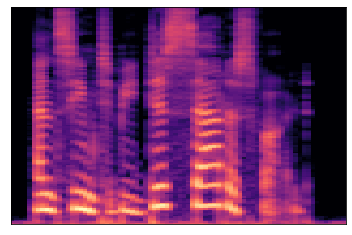

F1


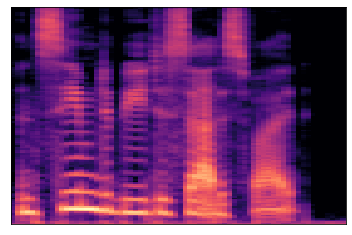

F2


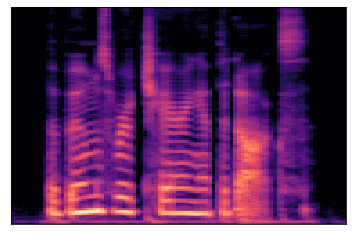

F3


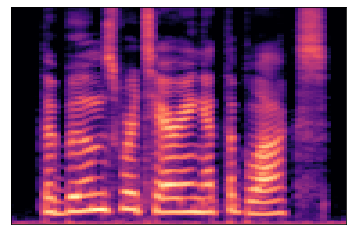

F4


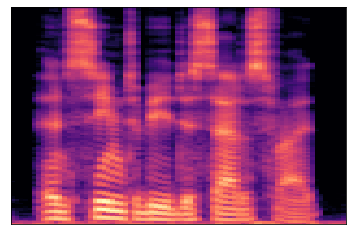

M1


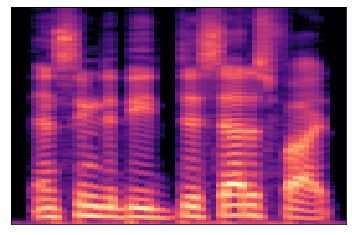

M2


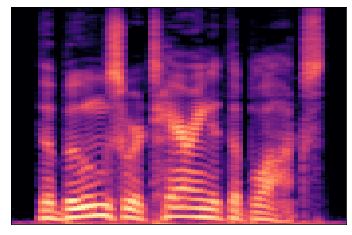

M3


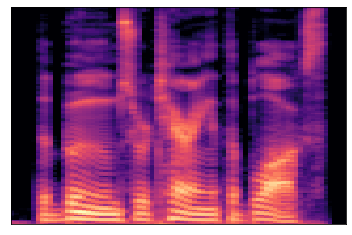

M4


In [4]:
for g in people:
    for filename in os.listdir(f'./vcc2018_training/{g}'):
        audioname = f'./vcc2018_training/{g}/{filename}'
        y, sr = librosa.load(audioname, mono=True, duration=30)
        msg = melspectrogram(y, sr)
        specshow(librosa.power_to_db(msg, ref=np.max))
        plt.savefig(f'{g[5:]}.png')
        plt.show()
        print(f'{g[5:]}')
        break

Though we have only visualized one phrase for each speaker, all the melspectrogramms are surely distinct. Before drawing any conclusions, we should check that these differences are not based on the fact that different phrases were said - let's visualize and compare some of first speaker's melspectrograms:

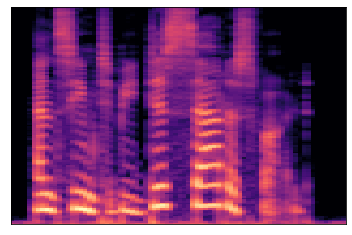

F1-1


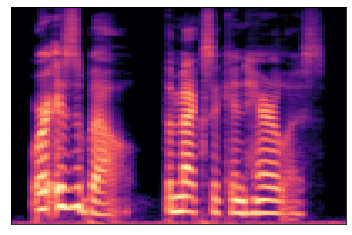

F1-2


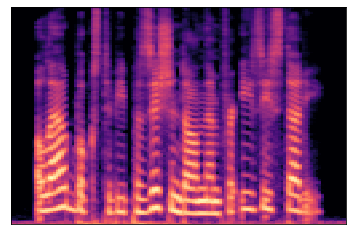

F1-3


In [5]:
# trainset
amount = 3
for g in people:
    for filename in os.listdir(f'./vcc2018_training/{g}'):
        audioname = f'./vcc2018_training/{g}/{filename}'
        y, sr = librosa.load(audioname, mono=True, duration=30)
        msg = melspectrogram(y, sr)
        specshow(librosa.power_to_db(msg, ref=np.max))
        plt.savefig(f'{g[5:]}.png')
        plt.show()
        print(f'{g[5:]}-{4 - amount}')
        amount -= 1
        if amount == 0:
            break
    break

The graphs are different along X axis, yet they have clear similarities - as example, light stripes (corresponding to large amplitudes) are located on approximately same altitudes - meaning that a speaker's voice has a finite set of frequencies it can work on. The principle is illustrated by the fact that first speaker's voice lines are curved, while second and forth's are far more straight.

These observations motivate to analyse each recorded fragment's spectrum.

There is a signal analysis method doing exacltly that - MFCC (mel-frequency cepstral coeffiecients) - and it's one of the most widely applied methods in signal analysis.

MFCC method works as follows:
~ signal amplitudes are converted from decibel to mel(as mels are perceived by human ear linearly: signal with amplitude of 2 mels sounds 2 times louder than a signal with amplitude of 1 mel, the same is incorrect for amplitudes in decibels)
~ cepstrum is built, meaning "spectrum of spectrum" (actually, it is Fourier transform of spectrum's logarithm). This construction allows to analyse, which frequencies dominate the spectrum
~ Finally, the coefficients themselves are derived, representing amplitudes of waves summing up to spectrum's logarithm

RandomForest will serve as base classifier for this solution. As an ensemble method based on bagging, it should have low variance, meaning working failry well on both test and train. Also, as its component DecisionTree's are prone to overfitting, RandomForest will provide low bias.

The code below implements the algorithm described above. Furthermore, it assesses classification quality based on $max\_depth$ parameter of RandomForest, as well as number of derived MFCCs $k$.

In [6]:
accs = []
md = [5, 10, 20]
for maxd in md:
    acc = []
    for k in np.arange(1, 40):
        header = ('speaker' +' MFCCS' * k).split()
        file = open('dataset.csv', 'w', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(header)
        file = open('testset.csv', 'w', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(header)
        # trainset
        for g in people:
            for filename in os.listdir(f'./vcc2018_training/{g}'):
                audioname = f'./vcc2018_training/{g}/{filename}'
                y, sr = librosa.load(audioname, mono=True, duration=30)
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = k)
                to_append = f'{people_dict[g]}'
                to_append += f' {(" ").join(str(e) for e in list(np.mean(mfccs.T,axis=0)))}'
                # print(to_append.split())
                file = open('dataset.csv', 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())
        train_csv = pd.read_csv('dataset.csv')
        X_train = train_csv.drop('speaker', axis=1)
        y_train = train_csv['speaker']
        # testset
        for g in people:
            for filename in os.listdir(f'./vcc2018_evaluation/{g}'):
                audioname = f'./vcc2018_evaluation/{g}/{filename}'
                y, sr = librosa.load(audioname, mono=True, duration=30)
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = k)
                to_append = f'{people_dict[g]}'
                to_append += f' {(" ").join(str(e) for e in list(np.mean(mfccs.T,axis=0)))}'
                # print(to_append.split())
                file = open('testset.csv', 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())
        test_csv = pd.read_csv('testset.csv')
        X_test = test_csv.drop('speaker', axis=1)
        y_test = test_csv['speaker']
        # model time
        model = RandomForestClassifier(max_depth = maxd)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc.append(accuracy(y_pred, y_test))
    accs.append(acc)

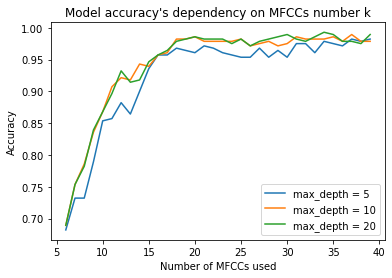

In [7]:
plt.plot(np.arange(6, 40), accs[0][5:], label='max_depth = 5')
plt.plot(np.arange(6, 40), accs[1][5:], label='max_depth = 10')
plt.plot(np.arange(6, 40), accs[2][5:], label='max_depth = 20')
plt.title("Model accuracy's dependency on MFCCs number k")
plt.xlabel('Number of MFCCs used')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Quality.png')
plt.show()

As it can be seen from the graph, provided deep enough trees and amount of MFCCs in segment [20;40] the classifier reaches accuracy of 0.992 on validation.

**Conclusion**

Method of mel-frequency cepstral coefficients combined with RandomForestClassifier can provide very precise predictions for speaker classification problem.